In [2]:
import json
import glob
from GPTUtils import query, prompts
from openai import OpenAI
def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
# openai (temp)
openai_api_key = open("openai_api_key").read()
openai_client=OpenAI(api_key=openai_api_key, timeout=10)

In [ ]:
# def identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables):
#     identify_var_type_prompt_list = []
#     response_format, extract_response_func = None, None
#     for chunk in all_chunks:
#         conversation = chunk['conversation']
#         prompt_variables['conversation'] = conversation_to_string(conversation)
#         identify_var_type_prompt, response_format, extract_response_func = prompts.identify_var_type_prompt_factory(system_prompt_blocks, user_prompt_blocks, prompt_variables)
#         identify_var_type_prompt_list.append(identify_var_type_prompt)
#     identified_var_types = query.multithread_prompts(openai_client, identify_var_type_prompt_list, response_format=response_format, temperature=0.0)
#     if response_format == 'json':
#         identified_var_types = [extract_response_func(i) for i in identified_var_types]
#     for (chunk_index, var_types) in enumerate(identified_var_types):
#         chunk = all_chunks[chunk_index]
#         chunk['var_types'] = var_types
#     return all_chunks

In [ ]:
# var_type_definitions = {
#     "driver": "fundamental human causes that lead to certain impacts on the environment to meet basic human needs.",
#     "pressure": "negative phenomena or activities affecting the environment or ecosystems, which are caused by drivers or occur naturally.",
#     "state": "the quantity and quality of physical, chemical, and biological phenomena within a specific timeframe and area.",
#     "impact": "adverse changes in environmental conditions, ecosystem functions, or human well-being.",
#     "response": "any behavior, action, or effort to protect the environment, address environmental issues, or be environmentally friendly."
# }
# for variable_definition_file in glob.glob("contexts/variable_definitions/*.json"):
#     variable_definitions = json.load(open(variable_definition_file))

In [ ]:
# prompt_variables = {
#     "var_types": "\n".join([f"{var_type}: {var_type_def}" for var_type, var_type_def in var_type_definitions.items()]),
# }
# prompts = json.load(open('prompts/identify_var_types.json'))
# system_prompt_blocks = prompts['system_prompt_blocks']
# user_prompt_blocks = prompts['user_prompt_blocks']
# all_chunks = []
# for chunk_file in glob.glob("data/v2/tmp/chunk/chunk_summaries_w_ktte/*.json"):
#     chunks = json.load(open(chunk_file))
#     all_chunks += chunks
# # identify the variables in three prompts:
# # First, identify if there are any mentions about the var types by extracting the sentences that mention the var types
# # all_chunks = all_chunks[:1] # test run
# system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
# user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
# all_chunks = identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)

# If so, identify the corresponding variables by assigning variables to the sentences
# If no existing variables can be matched, assign it to 'others'

In [ ]:
all_chunks = []
for chunk_file in glob.glob("data/v2/tmp/chunk/chunk_summaries_w_ktte/*.json"):
    chunks = json.load(open(chunk_file))
    all_chunks += chunks
len(all_chunks)
save_json(all_chunks, "data/v2/tmp/pipeline/init/chunks.json")

In [ ]:
var_type_definitions = json.load(open('GPTUtils/contexts/var_type_definitions.json'))
prompts = json.load(open('GPTUtils/prompts/identify_var_types.json'))
system_prompt_blocks = prompts['system_prompt_blocks']
user_prompt_blocks = prompts['user_prompt_blocks']
prompt_variables = {
    "var_types": "\n".join([f"{var_type}: {var_type_def}" for var_type, var_type_def in var_type_definitions.items()]),
}
all_chunks = json.load(open("data/v2/tmp/pipeline/init/chunks.json"))
print(len(all_chunks))
# all_chunks = all_chunks[:10]
system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
all_chunks = query.identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
save_json(all_chunks, "data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json")

In [ ]:
all_chunks = json.load(open("data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json"))

for chunk in all_chunks:
    var_type_result = chunk['identify_var_types_result']
    var_type_result = list(filter(lambda x: x["var_type"] != 'none', var_type_result))
    chunk['identify_var_types_result'] = var_type_result

save_json(all_chunks, "data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types_filtered.json")


In [ ]:
var_type_definitions = json.load(open('GPTUtils/contexts/var_type_definitions.json'))
var_definitions = {}
for var_type in var_type_definitions.keys():
    var_definitions_by_type = json.load(open(f"GPTUtils/contexts/variable_definitions/{var_type}_variables_def.json"))
    var_definitions[var_type] = var_definitions_by_type

prompts = json.load(open('GPTUtils/prompts/identify_vars.json'))
system_prompt_blocks = prompts['system_prompt_blocks']
user_prompt_blocks = prompts['user_prompt_blocks']
prompt_variables = {}
for var_type, var_type_def in var_type_definitions.items():
    prompt_variables[var_type] = {
        "definition": var_type_def,
        "vars": "\n".join([f"{var_name}: {var_def}" for var_name, var_def in var_definitions[var_type].items()])
    }
all_chunks = json.load(open("data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json"))
# all_chunks = all_chunks[:10]
system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
all_chunks = query.identify_vars(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
save_json(all_chunks, "data/v2/tmp/pipeline/identify_vars/chunk_w_vars.json")

In [ ]:
all_chunks = json.load(open("data/v2/user/pipeline/init/chunks.json"))
all_chunks = all_chunks[:10]
chunk_conversations = [query.conversation_to_string(chunk['conversation']) for chunk in all_chunks]
chunk_embeddings = query.multithread_embeddings(openai_client, chunk_conversations)
res = []
for (chunk_index, chunk_embedding) in enumerate(chunk_embeddings):
    res.append({
        "id": all_chunks[chunk_index]['id'],
        "embedding": chunk_embedding
    })
save_json(res, "data/v2/user/pipeline/init/chunk_embeddings.json")

In [ ]:
from pprint import pprint
def process_links(chunk_w_vars):
    links = []
    for chunk in chunk_w_vars:
        chunk_id = chunk['id']
        all_vars_in_chunk =  [(var_type, var_mention) for 
                              var_type, var_mentions in chunk['identify_vars_result'].items()
                              for var_mention in var_mentions]
        if len(all_vars_in_chunk) == 0: continue
        for i in range(len(all_vars_in_chunk)):
            for j in range(i+1, len(all_vars_in_chunk)):
                indicator1, var1 = all_vars_in_chunk[i]
                indicator2, var2 = all_vars_in_chunk[j]
                links.append({
                    "chunk_id": chunk_id,
                    "var1": var1['var'],
                    "var2": var2['var'],
                    "indicator1": indicator1,
                    "indicator2": indicator2,
                    "response": {
                        "relationship": "",
                        "evidence": ""
                    }
                })
    return links
chunk_w_vars = json.load(open("data/v2/user/pipeline/identify_vars/chunk_w_vars.json"))
links = process_links(chunk_w_vars)
links[1]

In [ ]:
all_chunks = json.load(open("data/v2/user/pipeline/identify_vars/chunk_w_vars.json"))
all_chunks = all_chunks[:10]
candidate_links = query.filter_candidate_links(all_chunks)
chunk_dict = {chunk['id']: dict(chunk, **{'identify_links_result':[]}) for chunk in all_chunks}
raw_variable_definitions = json.load(open('GPTUtils/contexts/variable_definitions.json'))
variable_definitions= {
    var_data['var_name']: var_data['definition']
    for var_list in raw_variable_definitions.values()
    for var_data in var_list
}

prompt_template = json.load(open('GPTUtils/prompts/identify_links.json'))
system_prompt_blocks = [prompt_block[1] for prompt_block in prompt_template['system_prompt_blocks']]
user_prompt_blocks = [prompt_block[1] for prompt_block in prompt_template['user_prompt_blocks']]
prompt_variables = {
    "links": candidate_links,
    "variable_definitions": variable_definitions,
}
prompt_list = []
chunk_id_list = []
link_metadata_list = []
print(len(candidate_links))
for link in candidate_links:
    if link['var1'] == '其他' or link['var2'] == '其他': continue
    conversation = chunk_dict[link['chunk_id']]['conversation']
    prompt_variables['conversation'] = query.conversation_to_string(conversation)
    prompt_variables['var1'] = f"{link['var1']}, {variable_definitions[link['var1']]}"
    prompt_variables['var2'] = f"{link['var2']}, {variable_definitions[link['var2']]}"
    prompt, response_format, extract_response_func = prompts.identify_link_prompt_factory(system_prompt_blocks, user_prompt_blocks, prompt_variables)
    prompt_list.append(prompt)
    chunk_id_list.append(link['chunk_id'])
    link_metadata_list.append(link) 
responses = query.multithread_prompts(openai_client, prompt_list, response_format=response_format, temperature=0.0)
if response_format == 'json':
    responses = [extract_response_func(i) for i in responses]
responses
for (response_index, extraction_result) in enumerate(responses):
    if extraction_result is None: continue
    chunk_id = chunk_id_list[response_index]
    chunk = chunk_dict[chunk_id]
    link_metadata = link_metadata_list[response_index]
    chunk["identify_links_result"].append({
        "chunk_id": link_metadata['chunk_id'],
        "var1": link_metadata['var1'],
        "var2": link_metadata['var2'],
        "indicator1": link_metadata['indicator1'],
        "indicator2": link_metadata['indicator2'],
        "response": extraction_result
    })
all_chunks = list(chunk_dict.values())
save_json(all_chunks, "data/v2/user/pipeline/identify_links/chunk_w_links.json") 

In [ ]:
import json
chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
def check_evidences(results, max_index):
    for evidences in results:
        for evidence in evidences:
            if evidence >= max_index:
                return False
    return True
for chunk in chunks:
    # var_type_evidences = [var_type['evidence'] for var_type in chunk['identify_var_types_result']]
    # var_evidences = [var['evidence'] for var_list in chunk['identify_vars_result'].values() for var in var_list] 
    link_evidences = [link['response']['evidence'] for link in chunk['identify_links_result']]
    if not check_evidences(link_evidences, len(chunk['conversation'])):
        print(chunk['id'])

In [3]:
def average_pairwise_jaccard(candidate_sets):
    from itertools import combinations
    total_jaccard_distance = 0
    pairs = list(combinations(candidate_sets, 2))
    for pair in pairs:
        set1, set2 = pair
        set1 = set(set1)
        set2 = set(set2)
        union = set1.union(set2)
        if len(union) == 0: continue
        intersection = set1.intersection(set2)
        jaccard_distance = (len(union) - len(intersection)) / len(union)
        total_jaccard_distance += jaccard_distance
    return total_jaccard_distance / len(pairs)



In [ ]:
import json
def merge_var_types(var_type_results):
    merged_var_types = {}
    for var_types in var_type_results:
        for var_type in var_types:
            if var_type['var_type'] not in merged_var_types:
                merged_var_types[var_type['var_type']] = var_type
        else:
            merged_var_types[var_type['var_type']]['evidence'] = list(set(merged_var_types[var_type['var_type']]['evidence'] + var_type['evidence']))
    return list(merged_var_types.values())
# identify var types
iteration_results = []
k=5
for _ in range(k):
    all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
    for chunk_index, chunk in enumerate(all_chunks):
        if len(iteration_results) <= chunk_index: iteration_results.append([])
        iteration_results[chunk_index].append(chunk['identify_var_types_result'])
for chunk_index, chunk in enumerate(all_chunks):
    ensemble_var_types = merge_var_types(iteration_results[chunk_index])
    candidate_var_types = list(map(lambda var_types: [x['var_type'] for x in var_types], iteration_results[chunk_index]))
    uncertainty = average_pairwise_jaccard(candidate_var_types)
    for var_type_result in ensemble_var_types:
        var_type_occurrence = len(list(filter(lambda candidate: var_type_result['var_type'] in candidate, candidate_var_types)))
        confidence = var_type_occurrence / k
        var_type_result['uncertainty'] = uncertainty
        var_type_result['confidence'] = confidence
    chunk['identify_var_types_result'] = ensemble_var_types
    if 'uncertainty' not in chunk: chunk['uncertainty'] = {}
    chunk['uncertainty']['identify_var_types'] = uncertainty

In [ ]:
from collections import defaultdict
def merge_vars(vars_results):
    merged_vars = {}
    for vars in vars_results:
        for var in vars:
            if var['var'] not in merged_vars:
                merged_vars[var['var']] = var
            else:
                merged_vars[var['var']]['evidence'] = list(set(merged_vars[var['var']]['evidence'] + var['evidence']))
    return list(merged_vars.values())
# identify vars
iteration_results = []
k=5
for _ in range(k):
    # all_chunks = query.identify_vars(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
    # all_chunks = json.load(open("data/v2/user/pipeline/identify_var_types/chunk_w_var_types.json"))
    all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
    for chunk_index, chunk in enumerate(all_chunks):
        if len(iteration_results) <= chunk_index: iteration_results.append(defaultdict(list))
        for var_type, vars in chunk['identify_vars_result'].items():
            # iteration_results[chunk_index][var_type].append(list(map(lambda x: x['var'], vars)))
            iteration_results[chunk_index][var_type].append(vars)
for chunk_index, chunk in enumerate(all_chunks[:3]):
    for var_type, vars in iteration_results[chunk_index].items():
        ensemble_vars = merge_vars(vars)
        candidate_vars = list(map(lambda var_list: [x['var'] for x in var_list], vars))
        vars_set = set([var for var_list in candidate_vars for var in var_list])
        uncertainty = average_pairwise_jaccard(candidate_vars)
        for var in vars_set:
            var_occurrence = len(list(filter(lambda candidate: var in candidate, candidate_vars)))
            confidence = var_occurrence / k
            var_index = list(map(lambda x: x['var'], ensemble_vars)).index(var)
            ensemble_vars[var_index]['confidence'] = confidence
            ensemble_vars[var_index]['uncertainty'] = uncertainty
            chunk['identify_vars_result'][var_type] = ensemble_vars
        if 'uncertainty' not in chunk: chunk['uncertainty'] = {}
        chunk['uncertainty']['identify_vars'] = uncertainty
print(all_chunks[2]['identify_vars_result'])

# save_json(all_chunks, "data/v2/user/pipeline/identify_vars/chunk_w_vars_w_uncertainty.json")

In [22]:
def merge_links(links_results):
    merged_links = {}
    for links in links_results:
        for link in links:
            link_id = f"{link['var1']}_{link['var2']}"
            if link_id not in merged_links:
                # remove after testing
                link['response']['relationship'] = [link['response']['relationship']]
                merged_links[link_id] = link
            else:
                merged_links[link_id]['response']['evidence'] = list(set(merged_links[link_id]['response']['evidence'] + link['response']['evidence']))
                merged_links[link_id]['response']['relationship'].append(link['response']['relationship'])

    return list(merged_links.values())

# identify links
iteration_results = []
k=5
for _ in range(k):
    all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
    for chunk_index, chunk in enumerate(all_chunks):
        if len(iteration_results) <= chunk_index: iteration_results.append([])
        iteration_results[chunk_index].append(chunk['identify_links_result'])
for chunk_index, chunk in enumerate(all_chunks[:3]):
    if chunk['identify_links_result'] == []: continue
    ensemble_links = merge_links(iteration_results[chunk_index])
    candidate_links = list(map(lambda links: [f"{x['var1']}_{x['var2']}" for x in links], iteration_results[chunk_index]))
    uncertainty = average_pairwise_jaccard(candidate_links)
    for link in ensemble_links:
        link_occurrence = len(list(filter(lambda candidate: f"{link['var1']}_{link['var2']}" in candidate, candidate_links)))
        confidence = link_occurrence / k
        link['uncertainty'] = uncertainty
        link['confidence'] = confidence
        # relationship confidence
        relationship_occurrences = defaultdict(int)
        for relationship in link['response']['relationship']:
            relationship_occurrences[relationship] += 1
        link['response']['relationship'] = []
        for relationship, occurrence_frequency in relationship_occurrences.items():
            relationship_confidence = occurrence_frequency / k
            link['response']['relationship'].append({
                "label": relationship,
                "confidence": relationship_confidence
            })
    chunk['identify_links_result'] = ensemble_links
    if 'uncertainty' not in chunk: chunk['uncertainty'] = {}
    chunk['uncertainty']['identify_links'] = uncertainty
print(all_chunks[1]['identify_links_result'][0])
print(all_chunks[1]['uncertainty'])
# save_json(all_chunks, "data/v2/user/pipeline/identify_links/chunk_w_links_w_uncertainty.json")

{'chunk_id': 'N1_1', 'var1': '住房', 'var2': '經濟', 'indicator1': 'driver', 'indicator2': 'driver', 'response': {'relationship': [{'relationship': 'positive', 'confidence': 1.0}], 'evidence': [1, 2, 3, 4, 8, 19], 'explanation': 'The transcript indicates a relationship between housing (住房) and the economy (經濟) through discussions about the availability of housing, land prices, and the impact of economic activities on local residents. The interviewee mentions how the demand for housing has increased due to new residents and how this has led to rising land prices, which reflects economic development. Additionally, the conversation highlights the challenges faced by local residents in accessing affordable housing and the economic implications of these issues, suggesting that housing availability is closely tied to economic conditions on the island.'}, 'uncertainty': 0.0, 'confidence': 1.0}
{'identify_links': 0.0}


In [5]:
prompts = [
    {
        "role": "system",
        "content": "Answer this questions for me: What are the drivers, pressures, states, impacts, and responses in the following text? Reply with the following JSON format: {{ answer: string }}", 
    },
    {
        "role": "user",
        "content": "The drivers are the fundamental human causes that lead to certain impacts on the environment to meet basic human needs. The pressures are negative phenomena or activities affecting the environment or ecosystems, which are caused by drivers or occur naturally. The states are the quantity and quality of physical, chemical, and biological phenomena within a specific timeframe and area. The impacts are adverse changes in environmental conditions, ecosystem functions, or human well-being. The responses are any behavior, action, or effort to protect the environment, address environmental issues, or be environmentally friendly."
    }
]
# response = query.request_gpt(openai_client, prompts, "gpt-4o-mini", 0.0, "json", None)
response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=prompts,
        # response_format={"type": "json_object"},
        temperature=0.0,
        seed=42,
    ),

print(response[0].choices[0].message.content)

{
  "answer": {
    "drivers": "The fundamental human causes that lead to certain impacts on the environment to meet basic human needs.",
    "pressures": "Negative phenomena or activities affecting the environment or ecosystems, which are caused by drivers or occur naturally.",
    "states": "The quantity and quality of physical, chemical, and biological phenomena within a specific timeframe and area.",
    "impacts": "Adverse changes in environmental conditions, ecosystem functions, or human well-being.",
    "responses": "Any behavior, action, or effort to protect the environment, address environmental issues, or be environmentally friendly."
  }
}


In [ ]:
import json
import glob

def prepare_for_finetuning(conversation, prompt):
    conversation = merge_consecutive(conversation)
    if len(conversation)  == 1:
        return None
    assert(len(conversation) > 1)
    conversation = reformat_conversation_direct(conversation, prompt)
    # conversations = reformat_conversation_reverse(conversation, prompt)
    return conversation
def merge_consecutive(conversation):
    merged_conversation = []
    for i, message in enumerate(conversation):
        if i == 0:
            merged_conversation.append(message)
            continue
        if conversation[i]['speaker'] == conversation[i-1]['speaker']:
            merged_conversation[-1]['content'] += conversation[i]['content']
        else:
            merged_conversation.append(message)
    return merged_conversation

def reformat_conversation_direct(conversation, prompt):
    finetune_messages = [
        {
            "role": "system",
            "content": prompt
        }, 
    ]
    for i in range(0, len(conversation), 2):
        if i == len(conversation) - 1:
            break
        assert(conversation[i]['speaker'] == 1)
        assert(conversation[i+1]['speaker'] == 0)
        finetune_messages.append(
            {
                "role": "user",
                "content": conversation[i]['content']
            })
        finetune_messages.append(
            {
                "role": "assistant",
                "content": conversation[i+1]['content']
            }
        )
    return {"messages": finetune_messages}

def reformat_conversations_reverse(conversation, prompt):
    finetune_messages = []
    for i in range(0, len(conversation), 2):
        if i == len(conversation) - 1:
            break
        assert(conversation[i]['speaker'] == 1)
        assert(conversation[i+1]['speaker'] == 0)
        messages = [
            {
                "role": "system",
                "content": prompt
            }, 
            {
                "role": "user",
                "content": conversation[i]['content']
            },
            {
                "role": "assistant",
                "content": conversation[i+1]['content']
            }
        ]
        finetune_messages.append(messages)
    return {"messages": finetune_messages}



In [ ]:

from pathlib import Path
instruction_prompt = """You are a residence of Lyudao, a small island near Taiwan. You are being interviewed about the situation on the island, ranging from environmental issues to social problems. Please answer the interview questions."""
for chunked_file in glob.glob("data/v2/user/chunk/chunk_summaries_w_ktte/*.json"):
    participant = chunked_file.split('/')[-1].split('.')[0]
    print(participant)
    chunks = json.load(open(chunked_file))
    all_examples = []
    for chunk in chunks:
        conversation = chunk['conversation']
        finetune_example = prepare_for_finetuning(conversation, instruction_prompt)
        if finetune_example is not None:
            all_examples.append(finetune_example)
    Path(f"data/finetune/{participant}").mkdir(parents=True, exist_ok=True)
    with open(f'data/finetune/{participant}/finetune_examples.jsonl', 'w') as outfile:
        for example in all_examples:
            json.dump(example, outfile, ensure_ascii=False)
            outfile.write('\n')

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a residence of Lyudao, a small island near Taiwan. You are being interviewed about the situation on the island, ranging from environmental issues to social problems. Please answer the interview questions."
    },
    {
        "role": "user",
        "content": "那你覺得，綠島對你來說是什麼？"
    }
]
prompts = [messages for _ in range(10)]
# model = "ft:gpt-4o-mini-2024-07-18:personal::9wD13Bqv"
participant = "general"
# model = "ft:gpt-4o-mini-2024-07-18:personal:lyudao-n5:9wFlzFxH"
model = "ft:gpt-4o-mini-2024-07-18:personal:lyudao-n7:9wIU4hNG"
# model = "gpt-4o-mini"
temperature = 0.5
responses = query.multithread_prompts(openai_client, prompts, model=model, temperature=temperature, seed=42)
save_json(responses, f"data/finetune/{participant}/finetune_responses_{temperature}.json")
# TODO: try inserting chunks

In [ ]:
import json
from DataUtils import dr
from collections import defaultdict
import jieba


def generate_DPSIR_data(chunks, var_type_mentions, variable_definitions, keyword_embeddings, stopwords=[], userdict=None):
    chunks_dict = {chunk['id']: chunk for chunk in chunks}
    for var_type, variables in variable_definitions.items():
        variables = {var_data['var_name']: var_data for var_data in variables}
        variable_definitions[var_type] = variables
    res = {}
    mentioned_chunk_ids = set()
    for var_type, var_type_data in var_type_mentions.items():
        res[var_type] = {
            "variable_type": var_type,
            "variable_mentions": {},
            "keyword_data": {
                "keyword_list": [],
                "keyword_coordinates": {},
                "keyword_statistics": {}
            }
        }
        for variable_data in var_type_data['variable_mentions'].values():
            variable_name = variable_data['variable_name']
            if variable_name not in res[var_type]['variable_mentions']:
                res[var_type]['variable_mentions'][variable_name] = {
                    "variable_name": variable_name,
                    "definition": variable_definitions[var_type][variable_name]['definition'] if variable_name in variable_definitions[var_type] else "unknown",
                    "factor_type": variable_definitions[var_type][variable_name]['factor_type'] if variable_name in variable_definitions[var_type] else "unknown",
                    "mentions": [],
                }
            res[var_type]['variable_mentions'][variable_name]['mentions'] += variable_data['mentions']
            mentioned_chunk_ids.update(list(map(lambda x: x['chunk_id'], variable_data['mentions'])))
        mentioned_chunk_data = [chunks_dict[chunk_id] for chunk_id in mentioned_chunk_ids]
        keyword_list, keyword_statistics, keyword_coordinates = generate_keyword_data(var_type, mentioned_chunk_data, keyword_embeddings, stopwords, userdict)
        res[var_type]['keyword_data'] = {
            "keyword_list": keyword_list,
            "keyword_statistics": keyword_statistics,
            "keyword_coordinates": keyword_coordinates
        }
    return res

def generate_keyword_data(var_type, chunks, keyword_embeddings, stopwords=[], userdict=None):

    keyword_embeddings_dict = {keyword['keyword']: keyword for keyword in keyword_embeddings}
    all_keywords = set()
    keyword_statistics = defaultdict(int)
    keyword_coordinates = {}
    for chunk in chunks:
        if chunk['identify_var_types_result'] == []: continue
        evidences = list(set([sentence_index for evidences in map(lambda x: x['evidence'], filter(lambda y: y['var_type'] == var_type, chunk['identify_var_types_result'])) for sentence_index in evidences]))
        print(evidences)
        evidence_messages = [chunk['conversation'][i]['content'] for i in evidences]
        chunk_keywords = set()
        for sentence in evidence_messages:
            words = jieba.cut(sentence)
            words = list(filter(lambda x: x not in stopwords, words))
            words = list(filter(lambda x: x in keyword_embeddings_dict, words))
            chunk_keywords.update(words)
        for keyword in chunk_keywords:
            keyword_statistics[keyword] += 1
        all_keywords.update(chunk_keywords)
    all_keywords = list(all_keywords) 
    keyword_statistics = {
        keyword: {
            "frequency": freq
            } 
        for keyword, freq in keyword_statistics.items()
    }
    # all_keyword_embeddings = [keyword_embeddings_dict[keyword]['embedding'] for keyword in all_keywords] 
    # XY = dr.scatter_plot(all_keyword_embeddings)
    # for keyword, coordinate in zip(all_keywords, XY):
    #     keyword_coordinates[keyword] = coordinate.tolist()
    return all_keywords, keyword_statistics, keyword_coordinates

nodes = {}
var_types = ["driver", "pressure", "state", "impact", "response"]
node_data_path = "data/v2/user/nodes/"
for var_type in var_types:
    nodes[var_type] = json.load(
        open(node_data_path + f"{var_type}_nodes.json", encoding="utf-8")
    )
variable_definitions = json.load(
    open("GPTUtils/contexts/variable_definitions.json", encoding="utf-8")
)
chunks = json.load(open("data/v2/user/pipeline/identify_var_types/chunk_w_var_types.json"))
keyword_embeddings = json.load(open("data/v2/user/keyword/keywords.json"))
stopwords = ["綠島"]
userdict = "data/v2/user/keyword/userdict.txt"
res = generate_DPSIR_data(chunks, nodes, variable_definitions, keyword_embeddings, stopwords, userdict)
from pprint import pprint

In [ ]:
keywords = json.load(open("data/v2/user/keyword/keywords.json"))
keyword_list = [keyword['keyword'] for keyword in keywords]
# write keyword to a txt file, each line is a keyword
with open("data/v2/user/keyword/userdict.txt", "w") as f:
    for keyword in keyword_list:
        f.write(f"{keyword}\n")

In [ ]:
keyword_embeddings = json.load(open("data/v2/user/keyword/keywords.json"))
kpca_reducer = dr.init_kpca_reducer(
    list(map(lambda x: x["embedding"], keyword_embeddings))
)

In [10]:
all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
for chunk in all_chunks:
    if "identify_vars" not in chunk['uncertainty']:
        chunk['uncertainty']['identify_vars'] = 0.0
    if "identify_links" not in chunk['uncertainty']:
        chunk['uncertainty']['identify_links'] = 0.0
save_json(all_chunks, "data/v2/user/pipeline/identify_links/chunk_w_links.json")

In [ ]:
text = ""
translation_prompt = [
    {
        "role": "system",
        "content": "You are a translator. Translate the user provided text into Traditional Chinese."
    },
    {
        "role": "user",
        "content": text
    }
]

In [3]:
all_chunks = json.load(open("data/v2/user/pipeline/identify_var_types/chunk_w_vars.json"))
for chunk in all_chunks:
    identify_vars_result = chunk['identify_vars_result']
    for var_type, var_list in identify_vars_result.items():
        var_list = list(filter(lambda x: x['explanation'] != "none", var_list))
        identify_vars_result[var_type] = var_list
    chunk['identify_vars_result'] = identify_vars_result
save_json(all_chunks, "data/v2/user/pipeline/identify_vars/chunk_w_vars_filtered.json")


In [6]:
from sklearn.cluster import AgglomerativeClustering
import json
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering
AgglomerativeClustering()
data = {}
data['cluster'] = list(map(lambda label: int(label), clustering.labels_))
json.dumps(data)


'{"cluster": [1, 1, 1, 0, 0, 0]}'

In [19]:
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


def high_dim_to_polar(data):
    # Step 1: Dimensionality Reduction
    reducer = TSNE(
            n_components=2,
            learning_rate="auto",
            init="random",
            perplexity=50,
            metric="cosine",
        )
    reduced_data = reducer.fit_transform(data)
    
    # Step 2: Calculate pairwise distances
    distances = squareform(pdist(reduced_data))
    
    # Step 3: Normalize distances to get angles
    d_max = np.max(distances)
    normalized_distances = distances / d_max  # Scale to [0, 1]
    angles = normalized_distances * 2 * np.pi


    
    # Step 4: Convert angles to polar coordinates
    # radial_distances = np.sqrt(np.sum(reduced_data ** 2, axis=1))  # Radial distance from origin
    polar_coords = []
    
    for i in range(len(angles)):
        for j in range(i + 1, len(angles)):
            polar_coords.append((angles[i, j], distances[i, j]))
    
    print(len(polar_coords), len(data))
    return polar_coords

def plot_polar_coordinates(polar_coords):
    # Plot polar coordinates
    plt.figure(figsize=(8, 8))
    for angle, r1, r2 in polar_coords:
        plt.polar([angle, angle], [0, r2], marker='o')
    plt.title("Polar Coordinate Representation of High-Dimensional Data")
    plt.show()

def verify_cyclic_arrangement(polar_coords):
    angles = []
    for angle, _, _ in polar_coords:
        angles.append(angle)
    
    angles = np.array(angles)
    
    # 1. Visual Inspection
    plt.figure(figsize=(8, 8))
    plt.subplot(121)
    plt.scatter(angles, np.zeros_like(angles), marker='o')
    plt.title("Angle Distribution")
    plt.xlabel("Angle (radians)")
    
    # 2. Calculate angle differences
    angle_diffs = np.diff(np.concatenate(([angles[-1] - 2 * np.pi], angles)))  # Wrap around
    angle_diffs = np.abs(angle_diffs)

    # 3. Check correlation with distance differences
    distances = squareform(pdist(np.array([[p[1], p[2]] for p in polar_coords])))  # Extract points
    distance_diffs = squareform(pdist(distances))
    
    # Correlate angle differences with distance differences
    correlation = np.corrcoef(angle_diffs[:-1], distances.flatten()[1:])
    
    plt.subplot(122)
    plt.scatter(range(len(angle_diffs)), angle_diffs, marker='o')
    plt.title("Angle Differences")
    plt.xlabel("Index")
    
    plt.tight_layout()
    plt.show()
    
    print("Correlation between angle differences and distance differences:", correlation[0, 1])

# Example usage:
if __name__ == "__main__":
    # Generate random high-dimensional data
    np.random.seed(0)
    high_dim_data = np.random.rand(100, 10)  # 100 samples in 10 dimensions

    polar_coords = high_dim_to_polar(high_dim_data)
    verify_cyclic_arrangement(polar_coords)

    # plot_polar_coordinates(polar_coords)

4950 100


ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
import numpy as np
from scipy.optimize import minimize

# Define the distance function d(a, b) as a given matrix
D = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]])  # Example distance matrix (3x3)
max_d = np.max(D)  # Maximum distance

# Initialize r(a, b) as a variable matrix
initial_r = np.ones(D.shape)  # Starting point (can be adjusted)

# Constraint for the sum of r(a,b)
def constraint_sum(r_flat):
    r = r_flat.reshape(D.shape)
    return np.sum(r[np.triu_indices_from(r, k=1)]) - 2 * np.pi

    return np.sum(r) - 4 * np.pi

# Objective function to minimize
def objective(r_flat):
    r = r_flat.reshape(D.shape)
    # Compute the objective function value
    # return np.sum((r / (2 * np.pi) - D / max_d)**2)
    return np.sum((r[np.triu_indices_from(r, k=1)] / (2 * np.pi) - D[np.triu_indices_from(D, k=1)] / max_d) ** 2)


# Define constraints
constraints = [{'type': 'eq', 'fun': constraint_sum}]

# Bounds (if necessary, for non-negativity)
epsilon = 1e-5  # Adjust as needed to ensure r(a, b) > 0
bounds = [(epsilon, None) for _ in range(D.size)]  # r(a,b) > epsilon
# bounds = [(0, None) for _ in range(D.size)]  # Non-negative values for r(a,b)


# Optimize
result = minimize(objective, initial_r.flatten(), constraints=constraints, bounds=bounds)

# Reshape the result back to r(a,b)
optimized_r = result.x.reshape(D.shape)

# Print the optimized r(a,b)
print("Optimized r(a,b):")
print(np.round(optimized_r * 180 / np.pi))  # Convert to degrees

# Print the objective value
print("Objective value:", result.fun)



Optimized r(a,b):
[[ 57.  60. 240.]
 [ 57.  57.  60.]
 [ 57.  57.  57.]]
Objective value: 0.3333333333333422


In [54]:
import numpy as np
from scipy.optimize import minimize

D = np.array([
    [0, 1, 1, 2], 
    [1, 0, 1, 2], 
    [1, 1, 0, 2],
    [2, 2, 2, 0]
    ])  # Example distance matrix (3x3)
# Objective function to minimize: deviation from R = alpha * D


def scaling(D):
    return  np.sqrt(D)
def objective(R_flat, D, n):
    R = R_flat.reshape((n, n))  # Reshape R_flat into an n x n matrix
    f_D = scaling(D)                  # Apply function f to the distance matrix D
    return np.sum((R - f_D)**2)  # Squared error between R and f(D)


# Constraint function: sum of R(a, b) = 4pi
# def constraint(R_flat):
#     return np.sum(R_flat) - 4 * np.pi
def constraint(R_flat):
    return np.sum(R_flat) - 4 * np.pi

# Initial guess for alpha

# Define constraints
# constraints = {'type': 'eq', 'fun': lambda R_flat: constraint(R_flat)}

n = D.shape[0]  # Dimension of the matrix
    
# Initial guess: start with f(D)
R_initial = scaling(D)

# Flatten the initial R matrix for the optimizer
R_initial_flat = R_initial.flatten()
# Bounds: Ensure 0 < R(a,b) < 2pi
epsilon = 1e-6  # Small positive value to ensure strict positivity
bounds = [(epsilon, 2 * np.pi) for _ in range(len(R_initial_flat))]
# Minimize the objective function with constraint
result = minimize(objective, R_initial_flat, args=(D, n),bounds=bounds)


if result.success:
    R_opt_flat = result.x
    R_opt = R_opt_flat.reshape((n, n))  # Reshape back to n x n
    print(np.round(R_opt * 180 / np.pi))  # Convert to degrees
else:
    raise ValueError("Optimization failed: " + result.message)




[[ 0. 57. 57. 81.]
 [57.  0. 57. 81.]
 [57. 57.  0. 81.]
 [81. 81. 81.  0.]]


True angles (radians): [0.         1.04719755 5.23598776 3.14159265]
True distance matrix D:
 [[0 1 1 3]
 [1 0 2 2]
 [1 2 0 2]
 [3 2 2 0]]

Optimized angles : [142.33469771  48.27839297 232.33467663 318.27835655]


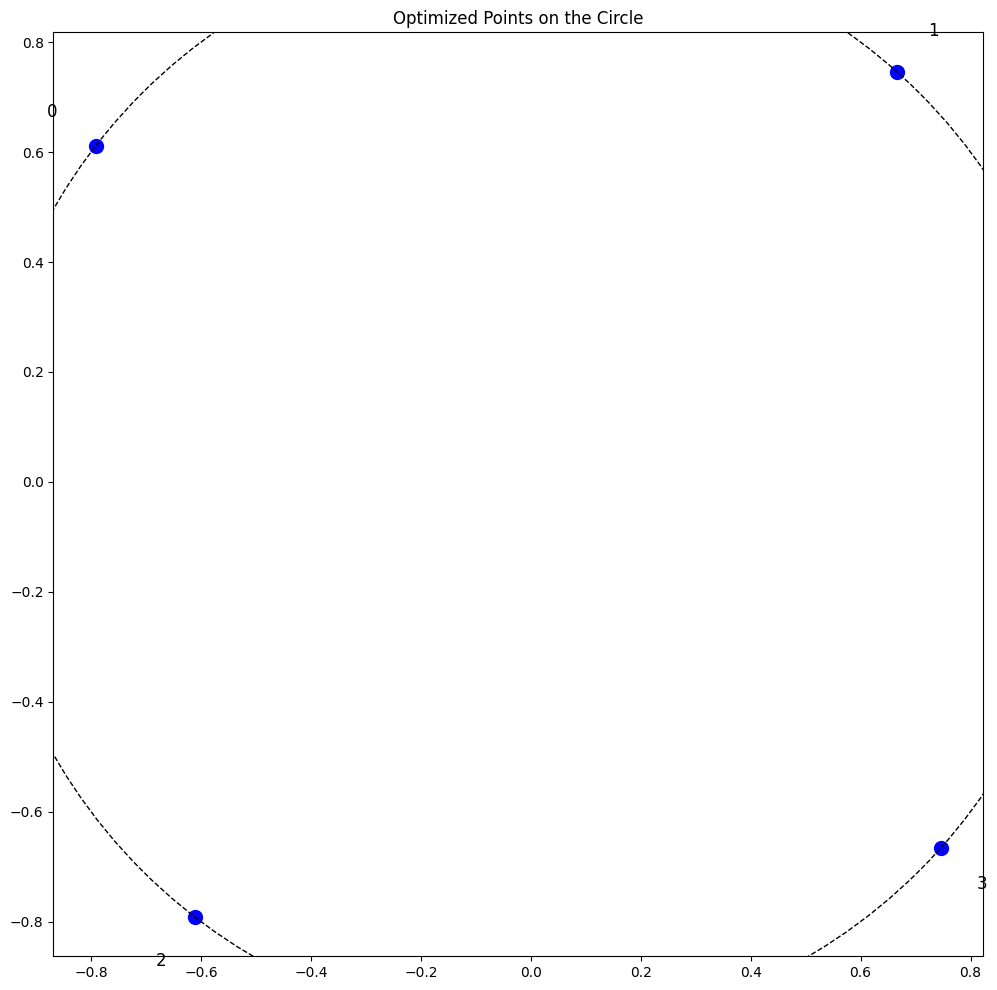

In [65]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def circular_distance(theta_i, theta_j):
    """Compute the circular distance between two angles."""
    return np.minimum(np.abs(theta_i - theta_j), 2 * np.pi - np.abs(theta_i - theta_j))

def objective(theta, D):
    """
    Objective function to minimize: sum of squared differences between
    circular distances and the given distance matrix D.
    
    Parameters:
    - theta: array of angles (in radians) for each point.
    - D: n x n distance matrix.
    
    Returns:
    - Sum of squared differences.
    """
    n = len(theta)
    # Compute pairwise circular distances
    d = np.minimum(np.abs(theta[:, np.newaxis] - theta[np.newaxis, :]),
                  2 * np.pi - np.abs(theta[:, np.newaxis] - theta[np.newaxis, :]))
    
    # Compute the difference only for i < j to avoid double counting and zero diagonals
    mask = np.triu(np.ones((n, n)), k=1).astype(bool)
    diff = d[mask] - D[mask]
    
    return np.sum(diff**2)

def optimize_positions(D, initial_theta=None, verbose=False):
    """
    Optimize the positions of points on a circle to preserve the distances in D.
    
    Parameters:
    - D: n x n distance matrix.
    - initial_theta: Optional initial guess for the angles.
    - verbose: If True, print optimization details.
    
    Returns:
    - Optimized angles theta (in radians).
    """
    n = D.shape[0]
    
    if initial_theta is None:
        # Initialize theta randomly between 0 and 2pi
        initial_theta = np.random.uniform(0, 2 * np.pi, n)
    
    # Define bounds for each theta: [0, 2pi]
    bounds = [(0, 2 * np.pi) for _ in range(n)]
    
    # Optionally, fix the first angle to 0 to remove rotational symmetry
    # Uncomment the following lines if you want to fix theta_0 = 0
    # bounds = [(0, 0)] + [(0, 2 * np.pi) for _ in range(n - 1)]
    
    # Define the objective function with D fixed
    obj = lambda theta: objective(theta, D)
    
    # Perform the optimization
    result = minimize(obj, initial_theta, method='L-BFGS-B', bounds=bounds, options={'disp': verbose})
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    optimized_theta = result.x
    return optimized_theta

def visualize_circle(theta):
    """
    Visualize the points on a circle.
    
    Parameters:
    - theta: array of angles (in radians) for each point.
    """
    x = np.cos(theta)
    y = np.sin(theta)
    
    plt.figure(figsize=(12,12))
    plt.scatter(x, y, c='blue', s=100)
    
    # Annotate points with their indices
    for idx, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi*1.1, yi*1.1, str(idx), fontsize=12, ha='center', va='center')
    
    # Draw the unit circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
    
    plt.axis('equal')
    plt.title('Optimized Points on the Circle')
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Example distance matrix for 4 points
    # Note: In practice, D should satisfy the properties of circular distances
    # Here, we create a sample D based on some true angles
    # true_theta = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
    true_theta = np.array([0, np.pi/3, 5*np.pi/3, np.pi])
    D_true = np.minimum(np.abs(true_theta[:, np.newaxis] - true_theta[np.newaxis, :]),
                        2 * np.pi - np.abs(true_theta[:, np.newaxis] - true_theta[np.newaxis, :]))
    D_true = np.array([
        [0, 1, 1, 3], 
        [1, 0, 2, 2], 
        [1, 2, 0, 2],
        [3, 2, 2, 0]
        ])  
    print("True angles (radians):", true_theta)
    print("True distance matrix D:\n", D_true)
    
    # Optimize to recover the angles
    optimized_theta = optimize_positions(D_true)
    
    print("\nOptimized angles :", optimized_theta * 180 / np.pi)  # Convert to degrees
    
    # Visualize the result
    visualize_circle(optimized_theta)
